In [1]:
import pandas as pd
import numpy as np
import fnmatch
import os

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [7]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, recall_score, r2_score, mean_squared_error

In [2]:
def repl(string):
    string1 = string.replace(']','').replace('[', '').replace('\'','')
    return string1

def str_to_list(string):
    lst = list(string[1:-1].split(", "))
    lst1 = []
    for el in lst:
        lst1.append(el[1:-1])
    
    return ' '.join(lst1)

In [3]:
def one_decimal(rating):
    return round(rating, 1)

def categorize_ratings(df, col):
    df[col] = df[col].apply(one_decimal)
    return df
def lower(text):
    return text.lower()

def lower_cols(df, cols):
    for col in cols:
        df[col] = df[col].apply(lower)
    return df

def remove_spaces(text):
    text = text.replace(' ', '', 10)
    return text

def join_names(df, col):
    df[col] = df[col].apply(remove_spaces)
    return df

def read_books_info(filespath='../data/big_data_temp/'):
    pattern = 'gr_books_df_*.csv'
    print('Pattern :', pattern )

    files = os.listdir(filespath) 
    dfs_files = []
    for name in files: 
        if fnmatch.fnmatch(name, pattern):
            dfs_files.append(name)
    dfs_files
    dfs_paths = []
    for file in dfs_files:
        dfs_paths.append(filespath + file)

    revs_lst = []
    for file in dfs_paths:
        try:
            revs_lst.append(pd.read_csv(file))
        except:
            print(f'file {file} failed')
    print(len(revs_lst))
    df = pd.concat(revs_lst,axis=0)
    return df

In [536]:
books_df = read_books_info()
books_df['author_name'] = books_df['author_name'].apply(repl)
books_df = categorize_ratings(books_df,'avg_rating')
books_df['genres'] = books_df['genres'].apply(str_to_list)
books_df = books_df[['isbn', 'book_title', 'avg_rating', 'author_name', 'book_desc', 'genres']]
books_df = lower_cols(books_df, ['book_title', 'author_name', 'book_desc', 'genres'])
books_df = join_names(books_df, 'author_name')

Pattern : gr_books_df_*.csv
6


In [538]:
books_df.head(2)

,isbn,book_title,avg_rating,author_name,book_desc,genres
0,1594488843,drive: the surprising truth about what motivat...,4.0,danielh.pink,the new york times bestseller that gives reade...,nonfiction business psychology leadership self...
1,033050889X,the mind's eye,3.9,oliversacks,"in musicophilia, oliver sacks explored music a...",nonfiction science psychology biology neurosci...


### Books features only : TfIdf for books_df

In [188]:
tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 1), min_df=0, stop_words='english', max_features=200)
tfidf_matrix = tf.fit_transform(books_df['genres'])

# tf.stop_words_
# tf.vocabulary_
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tf.get_feature_names())
books_df = pd.concat([books_df, tfidf_df], axis=1)
features = tf.get_feature_names()

In [187]:
tfidf_df.head(3)

,19th,20th,21st,academic,adult,adventure,africa,american,animals,anthologies,...,travel,trek,trivia,true,tv,unfinished,war,womens,world,writing
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.294656
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.409444,0.0,0.0,0.0,0.000000


In [189]:
content_df = pd.merge(reviews_df, books_df, how='left', left_on='ISBN', right_on='isbn').dropna()
content_df = content_df.drop(columns=['Unnamed: 0', 'isbn', 'book_title', 'author_name', 'book_desc', 'genres'])

In [190]:
X = content_df.copy()
y = X.pop('Rating')

In [191]:
y = y.apply(float)

In [192]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y)

In [193]:
X_train.columns[:50]

Index(['ISBN', 'UserID', 'index', 'avg_rating', '19th', '20th', '21st',
       'academic', 'adult', 'adventure', 'africa', 'american', 'animals',
       'anthologies', 'anthropology', 'apocalyptic', 'art', 'artificial',
       'astronomy', 'atheism', 'audiobook', 'autobiography', 'biography',
       'biology', 'birds', 'book', 'brain', 'british', 'buddhism', 'business',
       'canada', 'care', 'cartography', 'century', 'change', 'chemistry',
       'childrens', 'classics', 'climate', 'club', 'collections', 'comedy',
       'comic', 'comics', 'communication', 'computer', 'computers',
       'conservation', 'cooking', 'crime'],
      dtype='object')

In [194]:
user_isbn_train = X_train[['UserID', 'ISBN']]
user_isbn_test = X_test[['UserID', 'ISBN']]
X_train = X_train.drop(columns=['UserID', 'ISBN'])
X_test = X_test.drop(columns=['UserID', 'ISBN'])

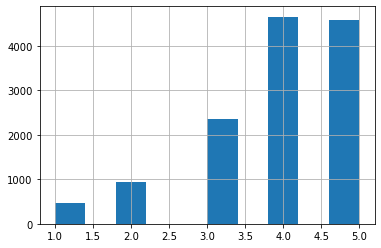

In [195]:
y_train.hist()

In [786]:
# Without SVD:

In [196]:
rfc=RandomForestRegressor(n_estimators=1000,max_depth=5, max_features='auto', n_jobs=-1)
rfc.fit(X_train,y_train)
y_pred=rfc.predict(X_test)

print(f'MSE =  {mean_squared_error(y_pred,y_test)}')
print(f'R2 = {r2_score(y_pred, y_test)}')

# gbc=GradientBoostingRegressor()
# gbc.fit(X_train,y_train)
# y_pred=gbc.predict(X_test)
# accuracy_score(y_pred,y_test)

df_pred = pd.DataFrame(y_pred)
df_test = pd.DataFrame(y_test)

df_test.reset_index()
df_test['Pred'] = y_pred[0]

df_test.describe()

MSE =  1.0596967726466437
R2 = -13.61854427576018


,Rating,Pred
count,3255.000000,3.255000e+03
mean,3.918280,3.732520e+00
std,1.068672,2.709360e-14
min,1.000000,3.732520e+00
25%,3.000000,3.732520e+00
50%,4.000000,3.732520e+00
75%,5.000000,3.732520e+00
max,5.000000,3.732520e+00


### Light FM

In [329]:
from lightfm import LightFM
from lightfm.data import Dataset

In [331]:
dataset = Dataset()
dataset.fit(reviews_df['UserID'],reviews_df['ISBN'])

In [339]:
dataset.fit_partial(items=books_df['isbn'], users=reviews_df['UserID'], item_features=features, user_features=None)

In [348]:
user_isbn = zip(reviews_df['UserID'], reviews_df['ISBN'])

In [349]:
(interactions, weights) = dataset.build_interactions(user_isbn)

In [335]:
np.array(books_df.loc[298,['isbn']])[0]

'0525954821'

In [343]:
list(tf_m_arr[0])

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.3768485485053178,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.24610936727437915,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.2249084177636906,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.40275026303800254,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.2984450681050103,
 0.0,
 0.0,
 0.0,
 0.3617456892004505,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.06540415309031819,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.24610936727437915,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.3431793038603882,
 0.0,
 0.12530726027986935,
 0.0,

In [345]:
tfidf_dct = tfidf_df.to_dict('index')

In [350]:
tf_m_arr = tfidf_matrix.toarray()

features_tuple = [(np.array(books_df.loc[i,['isbn']])[0], list(tfidf_dct[i])) for i in range(tf_m_arr.shape[0])]

In [351]:
item_features = dataset.build_item_features(features_tuple)

In [352]:
model = LightFM(loss='bpr')
model.fit(interactions, item_features=item_features)

In [373]:
model.predict([143], [234])

array([-3.58480263])

In [360]:
import numpy as np
from lightfm.datasets import fetch_movielens
movielens = fetch_movielens()

In [361]:
for key, value in movielens.items():
    print(key, type(value), value.shape)

train <class 'scipy.sparse.coo.coo_matrix'> (943, 1682)
test <class 'scipy.sparse.coo.coo_matrix'> (943, 1682)
item_features <class 'scipy.sparse.csr.csr_matrix'> (1682, 1682)
item_feature_labels <class 'numpy.ndarray'> (1682,)
item_labels <class 'numpy.ndarray'> (1682,)


In [362]:
train = movielens['train']
test = movielens['test']

In [369]:
train.toarray()

array([[5, 3, 4, ..., 0, 0, 0],
       [4, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [5, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 5, 0, ..., 0, 0, 0]], dtype=int32)

In [371]:
from lightfm import LightFM
from lightfm.evaluation import precision_at_k
from lightfm.evaluation import auc_score

model = LightFM(learning_rate=0.05, loss='bpr')
model.fit(train, epochs=10)

train_precision = precision_at_k(model, train, k=10).mean()
test_precision = precision_at_k(model, test, k=10).mean()

train_auc = auc_score(model, train).mean()
test_auc = auc_score(model, test).mean()

print('Precision: train %.2f, test %.2f.' % (train_precision, test_precision))
print('AUC: train %.2f, test %.2f.' % (train_auc, test_auc))

Precision: train 0.60, test 0.10.
AUC: train 0.90, test 0.86.


In [366]:
from scipy.sparse import coo_matrix

In [ ]:
coo_matrix(D)

In [368]:
coo_matrix (tfidf_matrix.toarray())

<299x186 sparse matrix of type '<class 'numpy.float64'>'
	with 3246 stored elements in COOrdinate format>

### ratings predition with random forest for the train set.

In [197]:
books_df = read_books_info()
books_df['author_name'] = books_df['author_name'].apply(repl)
books_df = categorize_ratings(books_df,'avg_rating')
books_df['genres'] = books_df['genres'].apply(str_to_list)
books_df = books_df[['isbn', 'book_title', 'avg_rating', 'author_name', 'book_desc', 'genres']]
books_df = lower_cols(books_df, ['book_title', 'author_name', 'book_desc', 'genres'])
books_df = join_names(books_df, 'author_name')
books_df.reset_index(inplace=True)

Pattern : gr_books_df_*.csv
6


In [198]:
reviews_df = pd.read_csv('../data/big_data_temp/reviews.csv')
# Keep some data for testing
reviews_df_train, reviews_df_test, ys_tr, ys_te = train_test_split(reviews_df, reviews_df['Rating'], test_size=0.2, stratify = reviews_df['Rating'])
reviews_df_test.to_csv('../data/big_data_temp/test_reviews.csv')
reviews_df = reviews_df_train

In [199]:
to_pivot = reviews_df[['UserID', 'ISBN','Rating']].drop_duplicates(subset=None, keep='first')
print(to_pivot[to_pivot[['UserID', 'ISBN']].duplicated()])

       UserID       ISBN  Rating
325     10631  802714625       5
66423    2232  521427088       4


In [202]:
to_pivot.drop(index=[325, 66423],inplace=True)

sparse_df = to_pivot.pivot(index='UserID', columns='ISBN', values='Rating')
sparse_df.fillna(0.0, inplace=True)

In [200]:
print(f'Number of users: {len(reviews_df.UserID.unique())}')
print(f'Max UserID: {max(reviews_df.UserID.unique())}')

Number of users: 11417
Max UserID: 12392


In [201]:
# Without SVD:

In [475]:
rfc=RandomForestRegressor(n_estimators=1000,max_depth=5, max_features='auto', n_jobs=-1)
rfc.fit(X_train,y_train)
y_pred=rfc.predict(X_test)

In [476]:
print(f'MSE =  {mean_squared_error(y_pred,y_test)}')
print(f'R2 = {r2_score(y_pred, y_test)}')

MSE =  1.063862485527479
R2 = -13.256476603236434


In [477]:
# gbc=GradientBoostingRegressor()
# gbc.fit(X_train,y_train)
# y_pred=gbc.predict(X_test)
# accuracy_score(y_pred,y_test)

In [479]:
df_pred = pd.DataFrame(y_pred)
df_test = pd.DataFrame(y_test)

In [480]:
df_test.reset_index()
df_test['Pred'] = y_pred[0]

In [481]:
df_test.describe()

,Rating,Pred
count,4054.000000,4.054000e+03
mean,3.914899,4.185964e+00
std,1.069003,3.979530e-13
min,1.000000,4.185964e+00
25%,3.000000,4.185964e+00
50%,4.000000,4.185964e+00
75%,5.000000,4.185964e+00
max,5.000000,4.185964e+00


In [25]:
sparse_df

ISBN,006145205X,014027541X,014311526X,033050889X,038535066X,038553082X,039330700X,039333810X,039335038X,039335279X,...,805095152,805390456,812967887,812975219,865478007,902543522X,91886570,91888050,91898242,965900584
UserID,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12387,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12388,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12389,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
books_df.head()

,index,isbn,book_title,avg_rating,author_name,book_desc,genres
0,0,1594488843,drive: the surprising truth about what motivat...,4.0,danielh.pink,the new york times bestseller that gives reade...,nonfiction business psychology leadership self...
1,1,033050889X,the mind's eye,3.9,oliversacks,"in musicophilia, oliver sacks explored music a...",nonfiction science psychology biology neurosci...
2,2,0465090796,quirkology: how we discover the big truths in ...,3.8,richardwiseman,"for over twenty years, psychologist professor ...",nonfiction psychology science audiobook scienc...
3,3,0684868768,"emergence: the connected lives of ants, brains...",4.0,stevenjohnson,in the tradition of being digital and the tipp...,science nonfiction science technology philosop...
4,4,067976867X,consilience: the unity of knowledge,3.9,edwardo.wilson,one of our greatest living scientists--and the...,science philosophy nonfiction science biology ...


In [760]:
### tfidf

In [203]:
tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 1), min_df=0, stop_words='english', max_features=200)
tfidf_matrix = tf.fit_transform(books_df['genres'])

# tf.stop_words_
# tf.vocabulary_
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tf.get_feature_names())

print(f'Indices of matrices are identical: {all(books_df.index == tfidf_df.index)}')

books_df = books_df.join(tfidf_df)
features = tf.get_feature_names()

Indices of matrices are identical: True


In [204]:
users = content_df.UserID.unique()
books = content_df.ISBN.unique()

n_u = len(users)
n_b = len(books)
n_u* n_b

226734

In [56]:
sparse_df

ISBN,006145205X,014027541X,014311526X,033050889X,038535066X,038553082X,039330700X,039333810X,039335038X,039335279X,...,805095152,805390456,812967887,812975219,865478007,902543522X,91886570,91888050,91898242,965900584
UserID,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12387,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12388,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12389,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [205]:
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import random as sparse_random
from sklearn.random_projection import sparse_random_matrix

svd = TruncatedSVD(n_components=5, n_iter=10, random_state=42)
svd.fit(sparse_df)

result = svd.transform(sparse_df)
result.shape

(11417, 5)

In [206]:
svd_5_df = pd.DataFrame(result, index=sparse_df.index)

In [207]:
svd_5_df

,0,1,2,3,4
UserID,,,,,
0,4.513819,1.246452,-0.386303,-4.135279,0.101371
1,0.590437,0.125460,0.005525,0.327129,-0.283737
2,0.174824,0.075062,0.029128,0.039472,-0.024850
3,0.087593,-0.052566,-0.012918,-0.010665,0.126244
4,0.156043,-0.027943,-0.002524,-0.039493,0.077491
...,...,...,...,...,...
12388,0.053133,0.002589,0.004552,0.023523,0.092236
12389,0.174824,0.075062,0.029128,0.039472,-0.024850
12390,0.116293,-0.063535,-0.085915,0.126243,0.071744


In [208]:
svd_5_df.reset_index(inplace=True)
# svd_5_df.rename(columns={'index':'UserID'},inplace=True)

In [209]:
svd_5_df

,UserID,0,1,2,3,4
0,0,4.513819,1.246452,-0.386303,-4.135279,0.101371
1,1,0.590437,0.125460,0.005525,0.327129,-0.283737
2,2,0.174824,0.075062,0.029128,0.039472,-0.024850
3,3,0.087593,-0.052566,-0.012918,-0.010665,0.126244
4,4,0.156043,-0.027943,-0.002524,-0.039493,0.077491
...,...,...,...,...,...,...
11412,12388,0.053133,0.002589,0.004552,0.023523,0.092236
11413,12389,0.174824,0.075062,0.029128,0.039472,-0.024850
11414,12390,0.116293,-0.063535,-0.085915,0.126243,0.071744
11415,12391,0.051047,-0.005201,-0.000071,0.033553,-0.027295


In [518]:
###content df preprocessing

In [210]:
content_df = pd.merge(reviews_df, books_df, how='left', left_on='ISBN', right_on='isbn').dropna()
content_df = content_df.drop(columns=['Unnamed: 0', 'isbn', 'book_title', 'author_name', 'book_desc', 'genres'])

content_df = pd.merge(content_df, svd_5_df, how='left',on='UserID').dropna()

content_df.drop(columns=['index'], inplace=True)

In [211]:
content_df

,ISBN,UserID,Rating,avg_rating,19th,20th,21st,academic,adult,adventure,...,unfinished,war,womens,world,writing,0,1,2,3,4
0,1771641495,3284,4,4.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,1.672322,0.256650,0.146779,0.320513,-0.094051
1,1416588256,11523,4,4.1,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.329761,0.0,0.0,0.0,0.000000,0.029155,-0.007502,-0.024698,0.036769,0.089153
2,006145205X,9867,4,4.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.185105,0.085729,0.040498,0.078036,0.066695
3,1594205213,1912,4,4.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.388796,0.104720,0.073705,0.298730,-0.154551
4,1851687793,11564,4,3.9,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.305845,0.0,0.0,0.0,0.000000,0.056322,-0.020952,-0.029054,0.060831,0.064236
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16213,1596914521,6259,4,4.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.338331,0.089596,0.005972,0.157921,0.337601
16214,046509760X,2426,4,4.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.259084,-0.065039,-0.107106,0.070088,0.198852
16215,1585422207,703,4,4.0,0.0,0.0,0.000000,0.348379,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.015807,0.003117,0.003494,0.025690,0.043346
16216,1846144329,7689,3,3.8,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.308662,0.0,0.0,0.0,0.000000,0.046662,-0.033852,0.040524,0.020056,0.043505


In [212]:
X = content_df.copy()
y = X.pop('Rating')

In [213]:
y = y.apply(float)

In [214]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y)

In [215]:
X_train.columns[:50]

Index(['ISBN', 'UserID', 'avg_rating', '19th', '20th', '21st', 'academic',
       'adult', 'adventure', 'africa', 'american', 'animals', 'anthologies',
       'anthropology', 'apocalyptic', 'art', 'artificial', 'astronomy',
       'atheism', 'audiobook', 'autobiography', 'biography', 'biology',
       'birds', 'book', 'brain', 'british', 'buddhism', 'business', 'canada',
       'care', 'cartography', 'century', 'change', 'chemistry', 'childrens',
       'classics', 'climate', 'club', 'collections', 'comedy', 'comic',
       'comics', 'communication', 'computer', 'computers', 'conservation',
       'cooking', 'crime', 'cultural'],
      dtype='object')

In [216]:
user_isbn_train = X_train[['UserID', 'ISBN']]
user_isbn_test = X_test[['UserID', 'ISBN']]
X_train = X_train.drop(columns=['UserID', 'ISBN'])
X_test = X_test.drop(columns=['UserID', 'ISBN'])

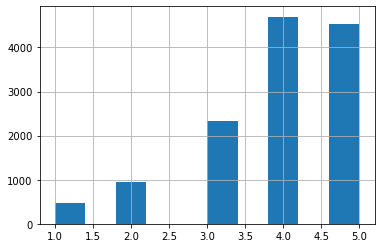

In [217]:
y_train.hist()

In [218]:
X_tr_arr = np.array(X_train)
tup = np.where(np.isnan(X_tr_arr))

In [159]:
# for i,j in zip(tup[0], tup[1]):
#     print(X_tr_arr[i,j])
np.unique(tup[0])

array([   59,   178,   293,   344,   630,   764,   803,   963,  1021,
        1084,  1100,  1122,  1170,  1355,  1457,  1476,  1530,  1706,
        1775,  1792,  1920,  2027,  2066,  2078,  2161,  2179,  2187,
        2273,  2407,  2664,  2739,  2767,  2769,  2829,  3254,  3299,
        3441,  3532,  3651,  3688,  3706,  3771,  3816,  3943,  3946,
        3983,  3986,  3994,  4066,  4073,  4272,  4278,  4395,  4405,
        4533,  4630,  4700,  4737,  4963,  5012,  5045,  5073,  5099,
        5105,  5137,  5395,  5504,  5551,  5571,  5661,  5703,  5760,
        5880,  5930,  5999,  6016,  6092,  6172,  6211,  6393,  6407,
        6650,  6783,  6905,  6951,  6976,  7001,  7071,  7110,  7200,
        7268,  7329,  7401,  7452,  7527,  7578,  7588,  7706,  7800,
        7879,  7888,  7957,  7978,  8143,  8327,  8364,  8394,  8508,
        8867,  8877,  8904,  9002,  9030,  9125,  9259,  9413,  9664,
        9690,  9701,  9826,  9852, 10005, 10332, 10342, 10412, 10457,
       10566, 10573,

In [158]:
X_train.iloc[:,[187, 188,189,190,191]]

,0,1,2,3,4
7405,0.289319,0.104466,0.058000,0.069576,0.113524
215,0.297500,0.136948,0.108194,0.094913,0.074526
15428,0.389053,0.303062,0.101919,0.177740,-0.304289
5181,0.250340,0.089164,0.110138,0.049889,0.048037
2188,0.097729,0.025490,0.024441,0.034410,0.015283
...,...,...,...,...,...
9011,0.033398,-0.003643,0.027115,0.015707,0.027908
13043,0.202540,0.130954,0.049942,0.101238,-0.181675
11659,1.937949,0.575604,0.352362,0.394535,-0.241548
10988,0.186006,0.187386,0.047188,0.128661,-0.383476


In [632]:
# With SVD:

In [219]:
rfc=RandomForestRegressor(n_estimators=1000,max_depth=5, max_features='auto', n_jobs=-1)
rfc.fit(X_train,y_train)
y_pred=rfc.predict(X_test)

print(f'MSE =  {mean_squared_error(y_pred,y_test)}')
print(f'R2 = {r2_score(y_pred, y_test)}')

df_pred = pd.DataFrame(y_pred)
df_test = pd.DataFrame(y_test)

df_test.reset_index()
df_test['Pred'] = y_pred[0]

df_test.describe()

MSE =  0.6512903672317288
R2 = -0.8560893664003604


,Rating,Pred
count,3244.000000,3.244000e+03
mean,3.914612,4.440555e+00
std,1.066021,8.705490e-14
min,1.000000,4.440555e+00
25%,3.000000,4.440555e+00
50%,4.000000,4.440555e+00
75%,5.000000,4.440555e+00
max,5.000000,4.440555e+00


In [ ]:
# rfc.predict(X_test)

In [220]:
X_test

,avg_rating,19th,20th,21st,academic,adult,adventure,africa,american,animals,...,unfinished,war,womens,world,writing,0,1,2,3,4
6717,4.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.223583,0.068192,0.059997,0.169792,0.182997
12892,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.616729,0.016181,0.161380,0.313078,-0.299231
14764,4.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.41288,0.0,0.0,0.0,0.0,0.671186,-0.019467,0.089432,0.159925,-0.036033
13533,4.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,4.770184,0.790306,0.505421,1.807436,0.913135
9933,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,1.234168,0.112500,0.179327,0.448839,0.668289
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6810,4.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.631215,-0.020689,0.031684,0.462174,0.293056
13186,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.195196,0.104042,0.038600,0.055664,-0.070700
183,4.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.088555,0.004314,0.007587,0.039205,0.153727
2899,4.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.035521,-0.041335,0.014195,-0.046597,0.055927


### Train the model on whole dataset:

In [223]:
all_df

,UserID,ISBN,avg_rating,19th,20th,21st,academic,adult,adventure,africa,...,travel,trek,trivia,true,tv,unfinished,war,womens,world,writing
0,11051,1101984597,4.2,0.0,0.0,0.0,0.0,0.387448,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,11051,1851687793,3.9,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.305845,0.0,0.0,0.0,0.0
2,11051,902543522X,3.9,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,11051,014027541X,4.1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,11051,159420229X,3.9,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226729,11404,059306173X,4.2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
226730,11404,039333810X,4.1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.315633,0.0,0.0,0.0,0.0
226731,11404,1594205213,4.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
226732,11404,055380202X,4.2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [227]:
svd_5_df

,UserID,0,1,2,3,4
0,0,4.513819,1.246452,-0.386303,-4.135279,0.101371
1,1,0.590437,0.125460,0.005525,0.327129,-0.283737
2,2,0.174824,0.075062,0.029128,0.039472,-0.024850
3,3,0.087593,-0.052566,-0.012918,-0.010665,0.126244
4,4,0.156043,-0.027943,-0.002524,-0.039493,0.077491
...,...,...,...,...,...,...
11412,12388,0.053133,0.002589,0.004552,0.023523,0.092236
11413,12389,0.174824,0.075062,0.029128,0.039472,-0.024850
11414,12390,0.116293,-0.063535,-0.085915,0.126243,0.071744
11415,12391,0.051047,-0.005201,-0.000071,0.033553,-0.027295


In [228]:
pairs = []
for user  in users:
    for book in books:
        dct = {}
        dct['UserID'] = user
        dct['ISBN'] = book
        pairs.append(dct)

all_df = pd.DataFrame(pairs)
all_df = pd.merge(all_df, books_df, how='left', left_on='ISBN', right_on='isbn')
all_df =all_df.drop(columns=['index', 'isbn', 'book_title', 'author_name', 'book_desc', 'genres'])
all_df = pd.merge(all_df, svd_5_df, how='left', on='UserID')
# all_df =all_df.drop(columns=['index'])
df_all = pd.merge(all_df, content_df[['UserID','ISBN','Rating']], how='left', on=['UserID','ISBN'])

rated_subset = df_all.dropna()
to_rate = df_all[df_all['Rating'].isna()]

X_to_rate = to_rate.copy()
y = X_to_rate.pop('Rating')
user_isbn_to_rate = X_to_rate[['UserID', 'ISBN']]
X_to_rate = X_to_rate.drop(columns=['UserID', 'ISBN'])

In [231]:
X = rated_subset.copy()
y = X.pop('Rating')

In [232]:
user_isbn_data = X[['UserID', 'ISBN']]
X = X.drop(columns=['UserID', 'ISBN'])

In [233]:
rfr=RandomForestRegressor(n_estimators=1000,max_depth=5, max_features='auto', n_jobs=-1)
rfr.fit(X,y)

RandomForestRegressor(max_depth=5, n_estimators=1000, n_jobs=-1)

In [235]:
user_isbn_data

,UserID,ISBN
0,11051,1101984597
22,11051,1984819194
26,11051,1771642483
30,11051,1473637465
45,11051,076790818X
...,...,...
238411,8490,1592406599
238495,9995,1565126831
238595,4282,1451697716
238610,5520,159420229X


In [239]:
X_to_rate = X_to_rate.dropna()

In [240]:
ratings_pred = rfr.predict(X_to_rate)
df_pred = pd.DataFrame(ratings_pred)

In [241]:
predicted_ratings_df = user_isbn_to_rate.reset_index().join(df_pred)

In [242]:
predicted_ratings_df = predicted_ratings_df.rename(columns={0:'Rating'}).drop(columns='index')

In [243]:
predicted_ratings_df.head(2)

,UserID,ISBN,Rating
0,11051,1851687793,3.883054
1,11051,902543522X,3.905493


In [244]:
rated_df = rated_subset[['UserID','ISBN','Rating']]

In [245]:
all_ratings_df = pd.concat([predicted_ratings_df,rated_df])

In [246]:
all_ratings_df.to_csv('../data/big_data_temp/predicted_ratings.csv')

In [247]:
reviews_df

,Unnamed: 0,ISBN,UserID,Rating
28547,280,465026567,8917,3
64393,291,805082115,8701,5
73424,209,7488807,12098,4
29991,246,192880519,9291,5
72453,134,61234001,4663,1
...,...,...,...,...
3308,76,553374117,3984,4
66545,134,521427088,7996,4
84190,159,60845503,5725,5
11378,226,61707803,8235,2


In [257]:
rated_subset[['UserID','ISBN', 'Rating']].to_csv('../data/big_data_temp/rated_subset.csv')

In [258]:
rated_subset

,UserID,ISBN,avg_rating,19th,20th,21st,academic,adult,adventure,africa,...,war,womens,world,writing,0,1,2,3,4,Rating
0,11051,1101984597,4.2,0.0,0.0,0.0,0.0,0.387448,0.0,0.0,...,0.0,0.0,0.0,0.000000,10.357119,2.003267,1.967048,5.101541,-8.135158,5.0
22,11051,1984819194,4.3,0.0,0.0,0.0,0.0,0.409466,0.0,0.0,...,0.0,0.0,0.0,0.358897,10.357119,2.003267,1.967048,5.101541,-8.135158,5.0
26,11051,1771642483,4.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,10.357119,2.003267,1.967048,5.101541,-8.135158,4.0
30,11051,1473637465,4.4,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,10.357119,2.003267,1.967048,5.101541,-8.135158,1.0
45,11051,076790818X,4.2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,10.357119,2.003267,1.967048,5.101541,-8.135158,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238411,8490,1592406599,3.9,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.163194,0.040481,0.006411,0.066493,0.027220,3.0
238495,9995,1565126831,3.8,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,1.795770,0.250515,0.371970,0.665041,-0.212307,3.0
238595,4282,1451697716,3.9,0.0,0.0,0.0,0.0,0.368820,0.0,0.0,...,0.0,0.0,0.0,0.000000,2.231255,0.916007,-0.521406,-4.123823,-0.354705,4.0
238610,5520,159420229X,3.9,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.548777,0.145667,0.088895,0.242027,-0.131941,4.0


In [260]:
books_df.to_csv('../data/big_data_temp/books.csv')